Note: this tutorial assumes basic knowledge of deep learning techniques. For an introduction into the subject, I recommend [3Blue1Brown's series](https://youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi) on Neural Networks and Deep Learning. 

In [1]:
%matplotlib inline

# Introduction to Autoencoders

Autoencoders are a type of feedforward artificial neural network (hereafter ANN) that attempt to reconstruct some input features $\vec{x}$ after first compressing it into a latent-space representation. In doing so, the Autoencoder learns the data representation in lower-dimensional space by extracting the most salient features of the data, ignoring insignificant noise, while minimizing the reconstruction error. Naturally, this has applications in dimensionality reduction, anomaly detection, image noise reduction, etc. Since Autoencoders can be trained on unlabeled data, it is a form of unsupervised learning. 

For further information on Autoencoders, see [Arden Dertat's article](https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798). 


An Autoencoder is comprised of 3 components: encoder, code, decoder; the encoder and decoder are themselves fully-connected feedforward ANNs, where usually (but not always) the structure of the decoder is a mirror image of the encoder. Accordingly, the code is simply a single layer of an ANN that holds the information needed to reconstruct the original input. 

In this tutorial, we'll attempt to build an Autoencoder model ourselves. Note that we shall mainly be using [PyTorch](https://pytorch.org/), though other libraries (e.g. [Keras](https://keras.io/) or [TensorFlow](https://www.tensorflow.org/)) are equally valid.

# Import Libraries and Set Hyperparameters

First, we import PyTorch, as well as our other dependencies.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

Next, we set the hyperparameters, namely, the batch size, number of training epochs, and the learning rate.

In [3]:
batch_size = 512
epochs = 20
learning_rate = 1e-3

# Loading and Preparing the Data

We shall train our Autoencoder using the MNIST dataset. The procedure is as follows: load the data in via the `torchvision` package, convert them into tensors using `torchvision.transforms.ToTensor()`, and download it to the directory specified in `root` (if it's not there already). Afterwards, we create a `torch.utils.data.DataLoader` object to prepare it for training. The test dataset is prepared in a similar manner.

In [4]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# Dataset
train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)
test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)
# Dataloader
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=10, shuffle=False
)


Extracting /root/torch_datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw




Extracting /root/torch_datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw




Extracting /root/torch_datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw




Extracting /root/torch_datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Building the Autoencoder Class

In the `__init__()` method,

* `nn.Linear` creates a linear function ($mx + c$) for each layer, such that we can later call an activation function to introduce non-linearity. 
* The `in_features` and `out_features` parameters set the size of the input and output tensors to a given layer, respectively. Notice that the `in_features` parameter in the first layer (`self.encoder_hidden_layer`) is exactly equal to the `out_features` parameter in the final layer (`self.decoder_output_layer`), since it's attempting to reconstruct the original input.

The `forward()` method defines the forward pass of a model, which occurs when we pass input tensors to an object of class `nn.Module`.

In [5]:
# For brevity, define the encoder and decoder layers together in one class
class Autoencoder(nn.Module):
    """A subclass of nn.Module, this Autoencoder class contains the hidden and output layers of 
    both the encoder and decoder components. Note that the size of the input and output tensors 
    for each layer is optimized for the MNIST dataset."""

    def __init__(self, **kwargs):
        super().__init__()
        # Encoder
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=128
        )
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=128
        )
        # Decoder
        self.decoder_hidden_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=kwargs["input_shape"]
        )

    def forward(self, features):
        """Returns the reconstruction of the original input tensor."""
        # Encoder
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.sigmoid(code)
        # Decoder
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.sigmoid(activation)
        return reconstructed

# Training on GPU

To help reduce training times, it's always a good idea to check if there's a GPU available. We do so by defining our current device as the first visible CUDA device (if one exists), and moving our Autoencoder object and its parameters over using the `to()` function.

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device
print(device)

cpu


Now, we simply declare an object from our Autoencoder class, and load it to our GPU/CPU.

In [7]:
# Create a model from the Autoencoder class, and load it to the device specified above
model = Autoencoder(input_shape=784).to(device)

Create an optimizer object to minimize the model's loss function. We adopt the convention of using Adam optimization and a mean-squared error (MSE) loss.

In [8]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Training the Model

Finally, we train our Autoencoder model for the number of epochs specified at the start, where at each epoch, we reset the gradients back to 0 using `optimizer.zero_grad()` to account for PyTorch accumulating gradients on subsequent passes.

In [9]:
for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader:
        # Reshape the mini-batch data to [N, 784] matrix, where N is the total number of inputs, and load it to the specified device
        batch_features = batch_features.view(-1, 784).to(device)
        
        # Reset the gradients back to 0. Note that PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # Compute reconstructions
        outputs = model(batch_features)
        
        # Calculate training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # Compute accumulated gradients
        train_loss.backward()
        
        # Update parameters based on current gradients
        optimizer.step()
        
        # Add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # Compute the epoch training loss
    loss = loss / len(train_loader)
    
    # Display the epoch training loss
    print("epoch : {}/{}, loss = {:.8f}".format(epoch + 1, epochs, loss))

epoch : 1/20, loss = 0.08577267
epoch : 2/20, loss = 0.06161010
epoch : 3/20, loss = 0.05715162
epoch : 4/20, loss = 0.04949571
epoch : 5/20, loss = 0.04359174
epoch : 6/20, loss = 0.03965875
epoch : 7/20, loss = 0.03580239
epoch : 8/20, loss = 0.03147178
epoch : 9/20, loss = 0.02968464
epoch : 10/20, loss = 0.02832338
epoch : 11/20, loss = 0.02660071
epoch : 12/20, loss = 0.02541634
epoch : 13/20, loss = 0.02427367
epoch : 14/20, loss = 0.02328591
epoch : 15/20, loss = 0.02256932
epoch : 16/20, loss = 0.02188804
epoch : 17/20, loss = 0.02127223
epoch : 18/20, loss = 0.02051072
epoch : 19/20, loss = 0.01980107
epoch : 20/20, loss = 0.01928816


# Testing our model

Let's use the test dataset we prepared previously to test our Autoencoder model.

In [10]:
test_examples = None

with torch.no_grad():
    for batch_features in test_loader:
        batch_features = batch_features[0]
        test_examples = batch_features.view(-1, 784)
        reconstruction = model(test_examples)
        break

# Visualizing our Results

To get a visual of what exactly our model is doing, let's also try to display a sample of our test images from our trained Autoencoder.

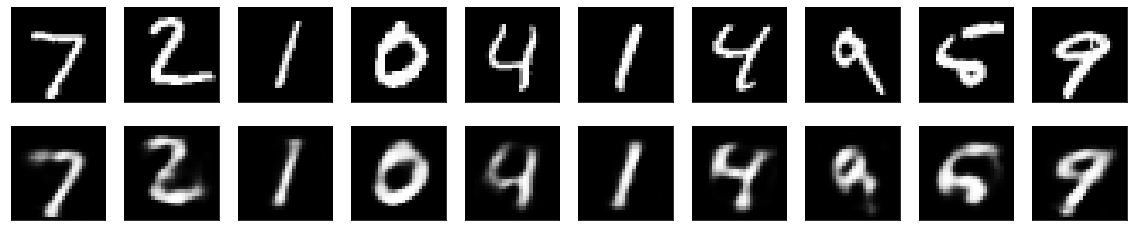

In [11]:
with torch.no_grad():
    number = 10
    plt.figure(figsize=(20, 4))
    for index in range(number):
        # Original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples[index].numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        # Reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(reconstruction[index].numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

As is the nature of machine learning, your results may vary depending on which local minimum your loss function achieves. Try playing around with the hyperparameters to see if you can minimize the Autoencoder's reconstruction error even further! One could also try letting the Autoencoder train on "noisy" images, which forces the model to learn the useful features of the data (as opposed to simply copying the input to its output) by subtracting out the random noise before reproducing the original "non-noisy" inputs. (*hint: you only have to change the inputs to the model*)

# Acknowledgements & Citations

This tutorial was written with the aid of Abien Fred Agarap's article: “Implementing an Autoencoder in PyTorch” (1). 

(1) Agarap, Abien Fred. “Implementing an Autoencoder in PyTorch”. Abien Fred Agarap, 26 Jan. 2020, [https://afagarap.works/2020/01/26/implementing-autoencoder-in-pytorch.html](https://afagarap.works/2020/01/26/implementing-autoencoder-in-pytorch.html).